In [1]:
# import libraries
import os
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices' # for tensorflow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from datetime import datetime
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

In [2]:
# Set the random seed for replicated results
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
# Load data from CSV file
data = pd.read_csv('dataset.csv', header=None)

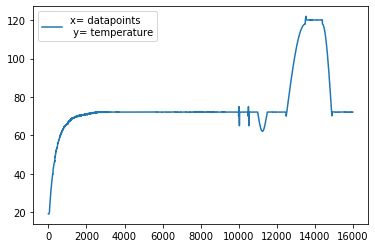

In [4]:
#plot the data 
plt.plot(data,label = 'x= datapoints \n y= temperature')
plt.legend()
plt.show()

In [5]:
raw_train_data = data.iloc[:10000]
raw_test_data = data.iloc[10000:]
raw_train_data.shape, raw_test_data.shape #returns (rows, columns)

((10000, 1), (6000, 1))

In [6]:
### scale the data
scaler = StandardScaler()
scaler = scaler.fit(np.array(raw_train_data).reshape(-1,1))
train_data = scaler.transform(np.array(raw_train_data).reshape(-1,1))
test_data = scaler.transform(np.array(raw_test_data).reshape(-1,1))


In [7]:
### create sequence
TIME_STEPS = 300

def create_sequences(dataset, time_steps=TIME_STEPS):
    """
    Creates sequences from the input data with the given time steps
    """
    X_out = []
    y_out = []
    for i in range(len(dataset) - time_steps):
        X_out.append(dataset[i:i+time_steps])
        y_out.append(dataset[i+time_steps])
    return np.array(X_out), np.array(y_out)

In [8]:
# Assuming you have a single column univariate data called 'data'
# We can create sequences with a specified number of time steps using the create_sequences function

X_train, y_train = create_sequences(train_data, TIME_STEPS)
X_test, y_test = create_sequences(test_data, TIME_STEPS)

# output format (number of sequence, length of batches, number of features)
print("Training input shape: ", X_train.shape)
print("Testing input shape: ", X_test.shape)

Training input shape:  (9700, 300, 1)
Testing input shape:  (5700, 300, 1)


In [9]:
# Define LSTM autoencoder model
model = Sequential()
model.add(LSTM(64, activation='tanh', input_shape=(TIME_STEPS, 1)))
##model.add(Dropout(rate=0.2))
model.add(RepeatVector(TIME_STEPS))
model.add(LSTM(64, activation='tanh', return_sequences=True))
##model.add(Dropout(rate=0.2))
model.add(TimeDistributed(Dense(1)))
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001), loss='mse')

In [10]:
# Train the model and save the history
history = model.fit(X_train, X_train, epochs=16, batch_size=400, validation_data=(X_test, X_test), verbose=1,)


Epoch 1/16
25/25 [==============================] - 34s 1s/step - loss: 0.4422 - val_loss: 9.4674
Epoch 2/16
25/25 [==============================] - 33s 1s/step - loss: 0.2666 - val_loss: 8.1297
Epoch 3/16
25/25 [==============================] - 32s 1s/step - loss: 0.1127 - val_loss: 7.7558
Epoch 4/16
25/25 [==============================] - 34s 1s/step - loss: 0.0617 - val_loss: 7.9096
Epoch 5/16
25/25 [==============================] - 34s 1s/step - loss: 0.0523 - val_loss: 7.9090
Epoch 6/16
25/25 [==============================] - 34s 1s/step - loss: 0.0463 - val_loss: 7.9156
Epoch 7/16
25/25 [==============================] - 34s 1s/step - loss: 0.0425 - val_loss: 7.8833
Epoch 8/16
25/25 [==============================] - 34s 1s/step - loss: 0.0398 - val_loss: 7.8347
Epoch 9/16
25/25 [==============================] - 35s 1s/step - loss: 0.0375 - val_loss: 7.7810
Epoch 10/16
25/25 [==============================] - 34s 1s/step - loss: 0.0349 - val_loss: 7.7467
Epoch 11/16
25/25 [

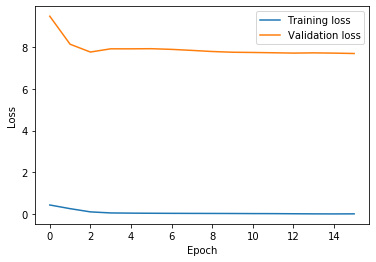

In [11]:
### Plot Training - Validation loss
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend();

In [12]:
# Make predictions on the train dataset
X_train_pred = model.predict(X_train, verbose=1)


304/304 [==============================] - 23s 75ms/step


In [13]:
# Calculate MAE loss on the train dataset
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)
# Flatten the train_mae_loss array
##train_mae_loss = train_mae_loss.flatten()


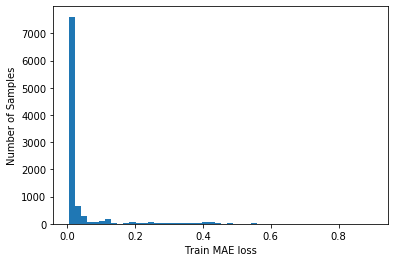

In [14]:
# Visualize MAE loss on the train dataset
plt.hist(train_mae_loss, bins=50)
plt.xlabel('Train MAE loss')
plt.ylabel('Number of Samples')
plt.show()

In [15]:
# Make predictions on the test dataset
X_test_pred = model.predict(X_test, verbose=1)


179/179 [==============================] - 14s 76ms/step


In [16]:
# Calculate MAE loss on the test dataset
test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)


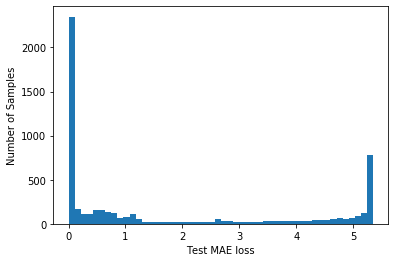

In [17]:
# Visualize MAE loss on the test dataset
plt.hist(test_mae_loss, bins=50)
plt.xlabel('Test MAE loss')
plt.ylabel('Number of Samples')
plt.show()

In [18]:
# Set the threshold for anomaly detection
# threshold = 0.5
threshold = np.mean(train_mae_loss) + 3 * np.std(train_mae_loss)

In [19]:
threshold

0.3360606929322643

In [20]:
# convert raw_test_data.to_numpy() array to fit in the table
sensor_data = raw_test_data.to_numpy()

# Create anomaly dataframe
anomaly_df = pd.DataFrame(columns=['Timesteps', 'Sensor_data', 'Test_loss', 'Threshold', 'Anomaly'])

# Add data to the anomaly dataframe
anomaly_df['Timesteps'] = range(TIME_STEPS, len(raw_test_data))
anomaly_df['Sensor_data'] = sensor_data[TIME_STEPS:]
anomaly_df['Test_loss'] = test_mae_loss

# Add the threshold column to the anomaly dataframe
anomaly_df['Threshold'] = threshold

# Find the anomalous data points
anomaly_df['Anomaly'] = anomaly_df['Test_loss'] > anomaly_df['Threshold']

# Print the anomaly dataframe
print(anomaly_df)

      Timesteps  Sensor_data  Test_loss  Threshold  Anomaly
0           300    72.117302   0.079404   0.336061    False
1           301    72.118553   0.080184   0.336061    False
2           302    72.117607   0.080736   0.336061    False
3           303    72.114029   0.081041   0.336061    False
4           304    72.107956   0.081142   0.336061    False
...         ...          ...        ...        ...      ...
5695       5995    72.121811   0.010479   0.336061    False
5696       5996    72.121788   0.010484   0.336061    False
5697       5997    72.121773   0.010494   0.336061    False
5698       5998    72.121758   0.010506   0.336061    False
5699       5999    72.121750   0.010493   0.336061    False

[5700 rows x 5 columns]


In [21]:
anomaly_df.head(3333)

,Timesteps,Sensor_data,Test_loss,Threshold,Anomaly
0,300,72.117302,0.079404,0.336061,False
1,301,72.118553,0.080184,0.336061,False
2,302,72.117607,0.080736,0.336061,False
3,303,72.114029,0.081041,0.336061,False
4,304,72.107956,0.081142,0.336061,False
...,...,...,...,...,...
3328,3628,120.121956,5.142836,0.336061,True
3329,3629,120.121895,5.144516,0.336061,True
3330,3630,120.121849,5.146188,0.336061,True
3331,3631,120.121811,5.147851,0.336061,True


In [22]:
anomaly_df['Test_loss']

0       0.079404
1       0.080184
2       0.080736
3       0.081041
4       0.081142
          ...   
5695    0.010479
5696    0.010484
5697    0.010494
5698    0.010506
5699    0.010493
Name: Test_loss, Length: 5700, dtype: float64

In [23]:
anomaly_df['Sensor_data']

0       72.117302
1       72.118553
2       72.117607
3       72.114029
4       72.107956
          ...    
5695    72.121811
5696    72.121788
5697    72.121773
5698    72.121758
5699    72.121750
Name: Sensor_data, Length: 5700, dtype: float64

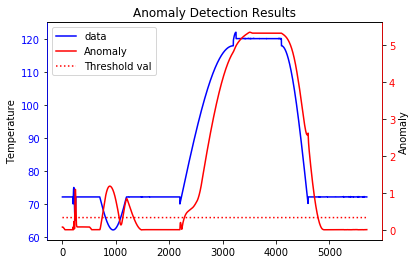

In [24]:
# Plot the anomaly dataframe and test dataset
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

color1 = 'blue'
color2 = 'red'

line1 = ax1.plot(anomaly_df.index, anomaly_df['Sensor_data'], color=color1, label = 'data')
line2 = ax2.plot(anomaly_df.index, anomaly_df['Test_loss'], color=color2, label = 'Anomaly')
line3 = ax2.plot(anomaly_df.index, anomaly_df['Threshold'], color='red', linestyle = 'dotted', label = 'Threshold val')

#ax2.set_ylim([-0.1, 1.1])
plt.title('Anomaly Detection Results')
plt.xlabel('Test data')
ax1.set_ylabel('Temperature')
ax2.set_ylabel('Anomaly')

ax2.spines['left'].set_color(color1)
ax2.spines['right'].set_color(color2)
ax1.tick_params(axis = 'y', labelcolor = color1)
ax2.tick_params(axis = 'y', labelcolor = color2)

lines = line1 + line2 + line3
labels = [l.get_label() for l in lines]
plt.legend(lines, labels, loc = "upper left")

plt.show()


In [25]:
anomaly_df.head(3333)

,Timesteps,Sensor_data,Test_loss,Threshold,Anomaly
0,300,72.117302,0.079404,0.336061,False
1,301,72.118553,0.080184,0.336061,False
2,302,72.117607,0.080736,0.336061,False
3,303,72.114029,0.081041,0.336061,False
4,304,72.107956,0.081142,0.336061,False
...,...,...,...,...,...
3328,3628,120.121956,5.142836,0.336061,True
3329,3629,120.121895,5.144516,0.336061,True
3330,3630,120.121849,5.146188,0.336061,True
3331,3631,120.121811,5.147851,0.336061,True


In [26]:
# Initialize variables for anomaly detection
window_size = 100
num_windows = int(len(test_data) / window_size)
consecutive_anomalies = 0

# Check each window of test data for anomalies
for i in range(num_windows):
    start_index = i * window_size
    end_index = start_index + window_size
    
    # Get the anomaly status for this window
    window_anomalies = df['anomaly'][start_index:end_index].values
    
    # Check if any anomalies were detected in this window
    if window_anomalies.sum() == 0:
        print(f"Window {i+1}: Normal Operation")
        consecutive_anomalies = 0
    else:
        print(f"Window {i+1}: Anomaly Detected")
        consecutive_anomalies += 1
        
        # Check if three consecutive windows had anomalies
        if consecutive_anomalies >= 3:
            print("Fault Detected!")
            consecutive_anomalies = 3

NameError: name 'df' is not defined